# Image Processing SS 20 - Assignment - 04

### Deadline is 20.5.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import random
from io import BytesIO
from PIL import Image

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - Qualify sharpness and noise - 5 Points

Determine the noise and sharpness in the images. Plot image number vs noise

Please download sample picture from [here](http://sipi.usc.edu/database/misc.zip) and place them next to your assignment (inside the misc folder).

In [3]:
# Load the pictures here
sample_images = []
direc = 'misc/' # directory of the sample pictures relative to your notebook
for number in [1,3,5,6]:
    sample_images.append(
        np.array(Image.open(direc+'4.2.0'+str(number)+'.tiff'))
    )
for name in ['house']:
    sample_images.append(
        np.array(Image.open(direc+name+'.tiff'))
    )

<BarContainer object of 5 artists>

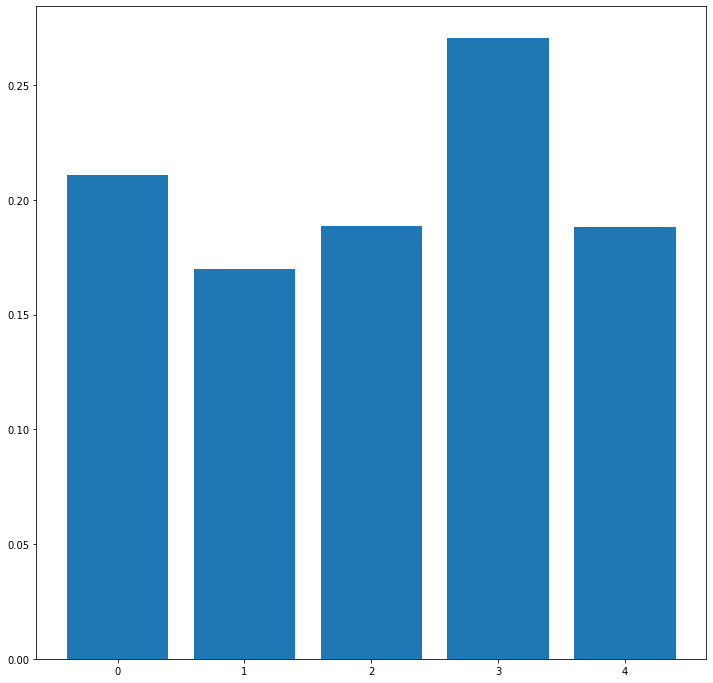

In [4]:
from skimage.color import rgb2grey

def qualify_noise(img):
    """Qualify the noise based on the std of a gaussian model.
       You may find a window that is contant in the images.
    """
    # your code here
    """
    slide 42 lecture "Image Processing"

    How can we measure the amount of noise in an image?
    We don’t know whether the changes of pixel brightness are due to texture or noise!
    Let’s first assume we know where in the image we have a homogeneous patch 
    (i.e.an image region with no texture, edges, gradients, etc).
    
    For estimating Gaussian Noise we have to calculate 2 parameters: sigma und mu
    The parameter mu  is the mean or expectation of the distribution (and also its median and mode); 
    and sigma  is its standard deviation. 
    The variance of the distribution is sigma^2
        
    Numpy function std: Returns the standard deviation, a measure of the spread of a distribution, 
    of the array elements. The standard deviation is computed for the flattened array by default, 
    otherwise over the specified axis.
    """
    grey_img = rgb2grey(img)
    # mu = np.mean(img)
    std = np.std(grey_img, dtype = np.float32) 
    return std
    

plt.bar(range(len(sample_images)), [qualify_noise(i) for i in sample_images])

<BarContainer object of 5 artists>

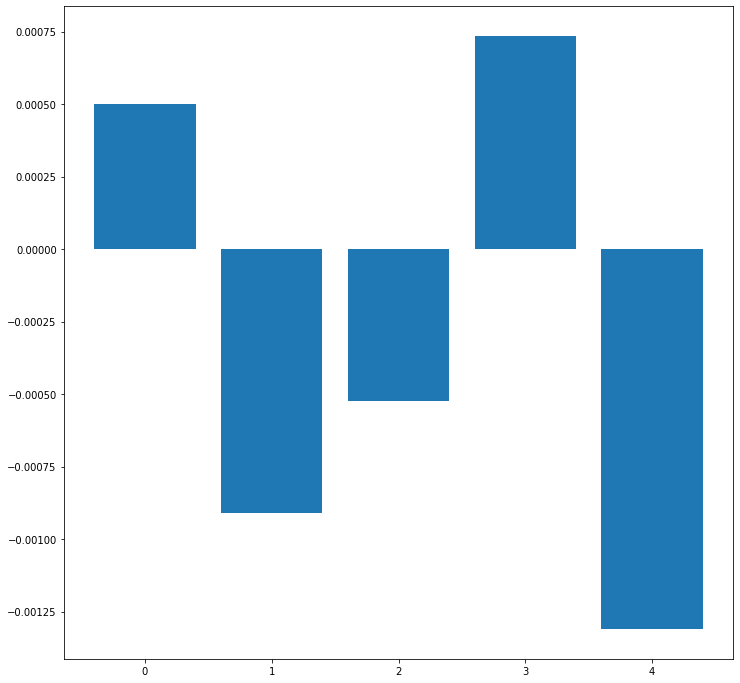

In [13]:
def qualify_sharpness(img):
    """Qualify the sharpness based on the average pixel differences."""
    # your code here
    """
    numpy.diff(a, n=1, axis=-1, prepend=<no value>, append=<no value>)[source]
    Calculate the n-th discrete difference along the given axis.
    """
    grey_img = rgb2grey(img)
    amount_of_pixels = grey_img.shape[0] * grey_img.shape[1]

    # Differences of Pixel brightness across line
    # in a NumPy array, axis 0 is the “first” axis. Assuming that we're talking 
    # about multi-dimensional arrays, axis 0 is the axis that runs downward down the rows.
    difference_array = np.diff(grey_img, axis=0)
    
    # summarize the difference
    sum_of_diff = np.sum(difference_array)
    
    result = sum_of_diff / amount_of_pixels
    
    return result
 

plt.bar(range(len(sample_images)), [qualify_sharpness(i) for i in sample_images])

Does the result match your expectations? If not what processing step can be done?

# Exercise 2 - SSIM JPEG Compression - 5 Points

In [14]:
def jpeg_enocde(img, quality):
    pil_img = Image.fromarray(img)
    buffer = BytesIO()
    pil_img.save(buffer, "JPEG", quality=quality)
    return buffer

def jpeg_decode(buffer):
    img = Image.open(buffer)
    return np.array(img)

def jpeg_quality_filter(img, quality):
    as_jpeg = jpeg_enocde(img, quality)
    return jpeg_decode(as_jpeg)

In [18]:
images_for_jpeg = sample_images[2::]
len(images_for_jpeg)

3

In [28]:
images10 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]
images50 = [jpeg_quality_filter(img, 50) for img in images_for_jpeg]
images80 = [jpeg_quality_filter(img, 80) for img in images_for_jpeg]

In [37]:
def calc_global_sigma(img, filtered_img, mue_img, mue_filtered_img):
        number_of_pixels = img.shape[0] * img.shape[1] - 1
        img_sum = 0
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                img_sum += (img[x,y] - mue_img) * (filtered_img[x,y] - mue_filtered_img)
        return img_sum/number_of_pixels

def ssim(img, filtered_img):
    """The SSIM similarity measure. Use the parameters from the paper 
    as on the second to last slide from the lecture"""
    # your code
    # img is original
    """
    Suppose x and y are two non-negative image signals, which have been aligned with eachother 
    (e.g., spatial patches extracted from each image). If we consider one of the signals 
    to have perfect quality, then the similarity measure can serve as a quantitative measurement 
    of the quality of the second signal. 
    """
    
    img = rgb2grey(img)
    filtered_img = rgb2grey(filtered_img)

    mu_orig = np.mean(img)
    mu_filtered = np.mean(filtered_img)
    
    std_orig = np.std(img, dtype = np.float32)
    std_filtered = np.std(img, dtype = np.float32)


    # Structure comparison is conducted after luminance subtraction and variance normalization.  
    # Specifically, we associate the two unit vectors (x−μx)/σx and (y−μy)/σy,
    # each lying in the hyperplane defined by Eq. (3), with thestructure of the two images. 
    # The correlation (inner product) between these is a simple and effective measure to quantify 
    # the structural similarity. Notice that the correlation between (x−μx)/σxand (y−μy)/σy 
    # is equivalent to the correlation coefficient between x and y.
    
    amount_of_pixels_unbiased = img.shape[0] * img.shape[1] - 1
    diff_orig = img - mu_orig
    diff_filtered = filtered_img - mu_filtered
    std_xy = np.sum(diff_orig * diff_filtered) / amount_of_pixels_unbiased

    # From papper: Image Quality Assessment: From Error Visibility to Structural Similarity 
    # For luminance comparison, we definel(x,y) = (2 * μ_x * μ_y + C1)/(μ_x^2 + μ_y^2 + C1)
    # where the constant C1 is included to avoid instability when μ2x+μ2y is very close to zero. 
    # Specifically, we choose C1= (K_1 * L)**2
    # where L is the dynamic range of the pixel values (255 for8-bit grayscale images), 
    # and K_1 < 1 is a small constant.
    
    luminance_c1 = (0.5 * 255) ** 2
    
    # The contrast comparison function takes a similar form:
    # c(x,y) = (2 * σ_xy + C2)/(σ_x^2 + σ_y^2 + C2)
    # where C2= (K2_2 * L)**2, and K_2 < 1.
    
    contrast_c2 = (0.00025 * 255) ** 2
    
    
    # specific form of the SSIM index (In order to simplify the expression,we set α = β = γ = 1 
    # and C3 = C2/2 in this paper)
    # Specific form of the SSIM for calculation:
    # SSIM(x,y) =((2 * μ_x * μ_y + C1)*(2 * σ_xy + C2))/((μ_x^2 + μ_y^2 + C1)*(σ_x^2 + σ_y^2 + C2))

    ssim_numerator = (2 * mu_orig * mu_filtered + luminance_c1) * (2 * std_xy  + contrast_c2)
    ssim_denominator = (mu_orig**2 + mu_filtered**2 + luminance_c1) * (std_orig**2 + std_filtered**2 + contrast_c2)
    
    ssim_result = float(ssim_numerator / ssim_denominator)
    
    
    print(ssim_result)
    return ssim_result
    

for i, img in enumerate(images_for_jpeg):
    print(i)
    compressed_images = [images10[i], images50[i], images80[i]]
    plt.bar(range(len(compressed_images)),
             [ssim(img, comp) for comp in compressed_images])
    plt.show()

0


NameError: name 'std_orig' is not defined